In [ ]:
!python --version


Python 3.12.12


In [ ]:
!pip install --upgrade pip
!pip install --upgrade mne numpy scipy matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 26.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 92.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 127.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 117.7 MB/s  0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [mne]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cupy-c

In [ ]:
import mne
print("MNE version:", mne.__version__)


MNE version: 1.10.2


Files: [PosixPath('/root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf'), PosixPath('/root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf'), PosixPath('/root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf')]
Reading EDF files...
<RawEDF | S001R06.edf, 64 x 60000 (375.0 s), ~29.3 MiB, data loaded>
Cleaning channel names for montage compatibility...
Montage set to standard_1020 successfully.
Applying notch filter at 50 Hz...
Applying bandpass filter 0.5-45 Hz...
Resampling to 128 Hz...
Computing PSD (Welch) for all EEG channels...
Computed delta power: shape (64,)
Computed theta power: shape (64,)
Computed alpha power: shape (64,)
Computed beta power: shape (64,)
Plotting topographic maps for each band...


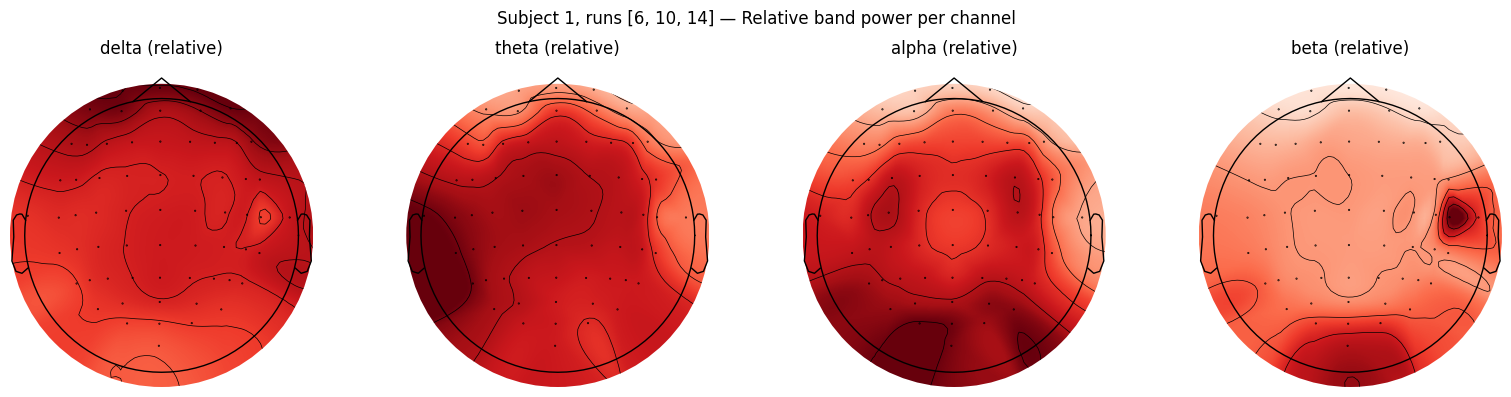

Plotting PSD for representative channel: FC5


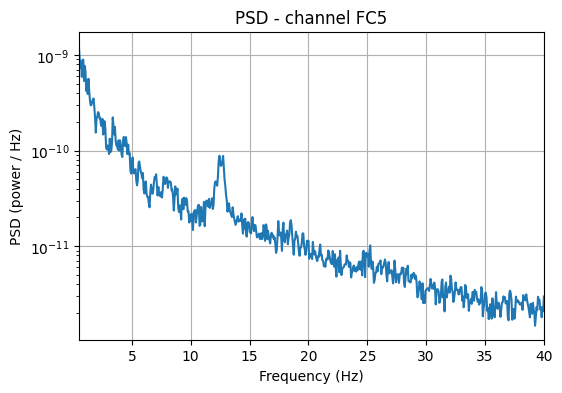

Extracting alpha-band envelope (Hilbert) for a visual example...


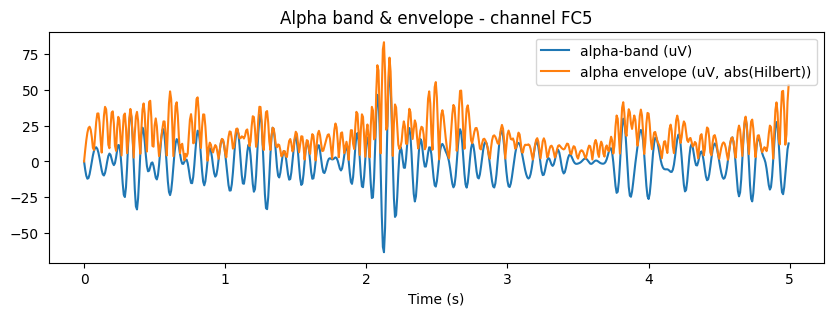

Saved band-power results to ./eeg_band_results


In [ ]:
"""
eeg_band_power_topomap.py

- Downloads PhysioNet EEG Motor Movement/Imagery dataset via MNE
- Loads EDF files for chosen subject and runs
- Preprocesses (notch, bandpass, resample)
- Computes band power (delta/theta/alpha/beta) per channel using Welch PSD
- Plots topographic maps of band power and example timeseries/spectra

Citations:
- MNE EEGBCI loader (mne.datasets.eegbci.load_data). See MNE docs.
- PhysioNet EEG Motor Movement/Imagery Dataset (EEGMMIDB).
"""

import os
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.datasets import eegbci
from mne.io import read_raw_edf
# For new versions of MNE (≥1.10)
psd_welch = lambda raw, **kwargs: raw.compute_psd(**kwargs)


# -----------------------
# USER PARAMETERS
# -----------------------
SUBJECT = 1                 # Subject ID (1..109)
RUNS = [6, 10, 14]          # Common motor imagery runs (example: runs 6,10,14). Change as desired.
DATA_PATH = os.path.expanduser('~/mne_data')   # where MNE will store dataset
RESAMPLE_SF = 128           # Hz - None to keep original
NOTCH_FREQ = 50             # set 50 or 60 depending on your mains frequency (set None to skip)
BAND_FREQS = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta' : (13, 30)
}

# -----------------------
# 1) Download file paths
# -----------------------
print('Downloading dataset file paths (only downloads once)...')
raw_fnames = eegbci.load_data(SUBJECT, RUNS, path=DATA_PATH, verbose=True)  # will download if needed
print('Files:', raw_fnames)

# -----------------------
# 2) Read and concatenate
# -----------------------
print('Reading EDF files...')
raws = [read_raw_edf(f, preload=True, stim_channel=None, verbose=False) for f in raw_fnames]
raw = mne.concatenate_raws(raws)
print(raw)

# -----------------------
# 3) Set montage (with channel name cleanup)
# -----------------------
print("Cleaning channel names for montage compatibility...")
new_names = {ch: ch.strip('.').upper() for ch in raw.ch_names}
raw.rename_channels(new_names)

try:
    montage = mne.channels.make_standard_montage('standard_1020')
    raw.set_montage(montage, match_case=False)
    print('Montage set to standard_1020 successfully.')
except Exception as e:
    print('Could not set montage:', e)


# -----------------------
# 4) Preprocessing: notch, bandpass, resample
# -----------------------
# Drop non-EEG channels if present
eeg_picks = mne.pick_types(raw.info, meg=False, eeg=True, exclude='bads')

# Notch filter (powerline)
if NOTCH_FREQ:
    print(f'Applying notch filter at {NOTCH_FREQ} Hz...')
    raw.notch_filter(freqs=NOTCH_FREQ, picks=eeg_picks, verbose=False)

# Broad bandpass to remove drifts and high freq noise
print('Applying bandpass filter 0.5-45 Hz...')
raw.filter(l_freq=0.5, h_freq=45.0, picks=eeg_picks, verbose=False)

# Resample for speed
if RESAMPLE_SF:
    print(f'Resampling to {RESAMPLE_SF} Hz...')
    raw.resample(RESAMPLE_SF, npad='auto')

# -----------------------
# 5) (Optional) Epoching around events
# -----------------------
# For simple band-power visualization across whole recordings, we can skip epoching.
# If you want trialwise comparisons, uncomment and adapt the following.

# events, event_id = mne.events_from_annotations(raw, verbose=False)
# print('Found events:', event_id)
# tmin, tmax = -1.0, 2.0
# epochs = mne.Epochs(raw, events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=(None, 0), preload=True)

# -----------------------
# 6) Compute PSD and band power per channel
# -----------------------
print('Computing PSD (Welch) for all EEG channels...')

# Modern MNE way (>=1.10)
psd = raw.compute_psd(fmin=0.5, fmax=40, n_fft=2048, n_overlap=512, verbose=False)
psds, freqs = psd.get_data(return_freqs=True)
# psds shape: (n_channels, n_freqs)


# Convert to power (µV^2/Hz). psd_welch returns power.
# For band power, integrate PSD across band (approx sum * df)
df = freqs[1] - freqs[0]
band_power = {}
for band, (fmin, fmax) in BAND_FREQS.items():
    freq_mask = (freqs >= fmin) & (freqs <= fmax)
    band_power[band] = np.sum(psds[:, freq_mask], axis=1) * df  # shape: (n_channels,)
    print(f'Computed {band} power: shape {band_power[band].shape}')

# Normalize across channels for plotting (relative power)
total_power = np.sum([band_power[b] for b in BAND_FREQS.keys()], axis=0)
relative = {}
for band in BAND_FREQS.keys():
    # avoid division by zero
    relative[band] = band_power[band] / (total_power + 1e-12)

# Get channel names in the same order
ch_names = [raw.ch_names[p] for p in eeg_picks]

# -----------------------
# 7) Plot topomaps for each band (averaged)
# -----------------------
print('Plotting topographic maps for each band...')
fig, axes = plt.subplots(1, len(BAND_FREQS), figsize=(4*len(BAND_FREQS), 4))
if len(BAND_FREQS) == 1:
    axes = [axes]
for ax, (band, vals) in zip(axes, relative.items()):
    im, cn = mne.viz.plot_topomap(vals, raw.info, axes=ax, show=False)
    ax.set_title(f'{band} (relative)')
fig.suptitle(f'Subject {SUBJECT}, runs {RUNS} — Relative band power per channel')
plt.tight_layout()
plt.show()

# -----------------------
# 8) Plot PSD for a representative channel
# -----------------------
rep_ch = ch_names[0]  # first EEG channel
print(f'Plotting PSD for representative channel: {rep_ch}')
ch_idx = ch_names.index(rep_ch)
plt.figure(figsize=(6,4))
plt.semilogy(freqs, psds[ch_idx, :])
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (power / Hz)')
plt.title(f'PSD - channel {rep_ch}')
plt.xlim(0.5, 40)
plt.grid(True)
plt.show()

# -----------------------
# 9) Example time-domain: filtered alpha band and Hilbert envelope (for visualization)
# -----------------------
print('Extracting alpha-band envelope (Hilbert) for a visual example...')
alpha_raw = raw.copy().filter(l_freq=BAND_FREQS['alpha'][0], h_freq=BAND_FREQS['alpha'][1], picks=eeg_picks, verbose=False)
alpha_data, times = alpha_raw.get_data(return_times=True)
# Hilbert envelope
from scipy.signal import hilbert
env = np.abs(hilbert(alpha_data.T)).T  # shape (n_channels, n_times)
# plot first 5s of first channel
t0_idx = 0
t1_idx = min(alpha_raw.n_times, int(5 * alpha_raw.info['sfreq']))
plt.figure(figsize=(10,3))
plt.plot(times[t0_idx:t1_idx], alpha_data[0, t0_idx:t1_idx] * 1e6, label='alpha-band (uV)')
plt.plot(times[t0_idx:t1_idx], env[0, t0_idx:t1_idx] * 1e6, label='alpha envelope (uV, abs(Hilbert))')
plt.xlabel('Time (s)')
plt.legend()
plt.title(f'Alpha band & envelope - channel {rep_ch}')
plt.show()

# -----------------------
# 10) Save results (optional)
# -----------------------
out_dir = './eeg_band_results'
os.makedirs(out_dir, exist_ok=True)
np.savez(os.path.join(out_dir, f'subj{SUBJECT}_runs{"_".join(map(str,RUNS))}_bandpower.npz'),
         band_power=band_power, relative=relative, ch_names=ch_names, freqs=freqs)
print('Saved band-power results to', out_dir)


In [ ]:
import os

# Create folder if it doesn’t exist
os.makedirs('./outputs', exist_ok=True)

# Now save figures safely
fig.savefig('./outputs/topomap.png')
plt.savefig('./outputs/psd_fc5.png')
plt.savefig('./outputs/alpha_envelope.png')

print(" Figures saved in ./outputs/")


 Figures saved in ./outputs/


<Figure size 640x480 with 0 Axes>